In [1]:
import numpy as np
from scipy.integrate import odeint, simps
from numba import jit

# @jit
# def kahan_sum(a, axis=0):
#     '''Kahan summation of the numpy array along an axis.
#     '''
#     s = np.zeros(a.shape[:axis] + a.shape[axis+1:])
#     c = np.zeros(s.shape)
#     for i in range(a.shape[axis]):
#         # https://stackoverflow.com/a/42817610/353337
#         y = a[(slice(None),) * axis + (i,)] - c
#         t = s + y
#         c = (t - s) - y
#         s = t.copy()
#     return s

def radial_schrod_deriv(y, r, l, E, Z=1,vr=None):
    '''
    The radial Schrödinger equation for hydrogen-like atom is

        u''(x) - [(l(l+1)/x^2) - (2Z/x) - E]u(x) = 0 

    Since it is a second-order equation, i.e. 
    
        y'' + g(x)y(x) = 0

    To use scipy.integrate.odeint, we can turn this equation into two
    first-order equation by defining a new dependent variables
    
        y'(x) = z(x)
        z'(x) = -g(x)y(x)

    Then we can solve this system of ODEs using "odeint" wit list. 
    '''
    
    (u, up) = y
    if vr is None:
        vr = -Z

    return np.array([
        up, 
        ((l*(l+1) / r**2) + (2* vr / r) - E) * u
    ])

def schroedinger_derivative_relativistic_correct(y, r, l, e, Z=1, vr=None):
    if vr is None:
        vr = -Z
        dvdr = -Z/r**2
    else:
        dvdr = (vr.derivative(n=1)(r)-vr(r)/r)/r
    # fine structure constant
    alpha = 7.2973525693e-3 
    (u, up) = y
    
    # note vr is effective potential multiplied by radius:
    return np.array([up, (l * (l + 1) / r ** 2 + 2 * vr / r - e - 1/4*alpha**2 *(e-2*vr/r)**2 + 1/2*alpha**2*l/r*dvdr) * u ])


def radial_wfc_scipy(r0, n=1, l=0, Z=1, E=None, vr=None, direction='F', du=0.1,state='Bounded'):
    '''
    Get the radial wavefunction by integrating the equation with
    scipy.integrate.odeint.
    '''

    assert direction.upper() in ['F', 'B','FR','BR']
    if E is None:
        if direction.upper() in ['F', 'B']:
            E = -Z**2 / n**2
        else:
            alpha = 1/137.
            j = l +1/2
            E = -Z**2 / n**2-alpha**2*Z**4/4/n**4*(4*n/(j+1/2)-3)

    # forward integration 
    if direction.upper() == 'F':
        ur = odeint(radial_schrod_deriv, [0.0, du], r0, args=(l, E, Z, vr))[:,0]

    # back integration 
    elif direction.upper() == 'B':
        ur = odeint(radial_schrod_deriv, [0.0, -du], r0[::-1], args=(l, E, Z, vr))[:,0][::-1]

    elif direction.upper() == 'FR':
        ur = odeint(schroedinger_derivative_relativistic_correct, [0.0, du], r0, args=(l, E, Z, vr))[:,0]

    elif direction.upper() == 'BR':
        ur = odeint(schroedinger_derivative_relativistic_correct, [0.0, -du], r0[::-1], args=(l, E, Z, vr))[:,0][::-1]

    # normalization
    if state == 'Bounded':
        ur /= np.sqrt(simps(ur**2, x=r0))
    elif state == 'Continuum':
        k = np.sqrt(E)
        ur = ur / ur.max() / np.sqrt(k) / np.sqrt(np.pi)
    return ur




def radial_wfc_numerov_backward(r0, n=1, l=0, Z=1, E=None,vr=None, du=0.001,state='Bounded'):
    '''
    Numerov algorithm
    
                  [12 - 10f(n)]*y(n) - y(n-1)*f(n-1)
        y(n+1) = ------------------------------------
                               f(n+1)

    where
        
        f(n) = 1 + (h**2 / 12)*g(n)

        g(n) = [E + (2*Z / x) - l*(l+1) / x**2]
    '''

    ur = np.zeros(r0.size)
    fn = np.zeros(r0.size)

    if E is None:
        E = -Z**2 / n**2
    
    if vr is None:
        vr = Z

    ur[-1] = 0.0
    ur[-2] = du

    dr  = r0[1] - r0[0]
    h12 = dr**2 / 12.

    gn = -((l*(l+1) / r0**2) - (2*vr / r0) - E)
    fn = 1. + h12 * gn

    for ii in range(r0.size-3,-1,-1):
        ur[ii] = (12 - 10*fn[ii+1]) * ur[ii+1] - \
                 ur[ii+2] * fn[ii+2]
        ur[ii] /= fn[ii]

    # normalization
    if state == 'Bounded':
        ur /= np.sqrt(simps(ur**2, x=r0))
    elif state == 'Continuum':
        ur = ur / ur.max() / (E) ** 0.25 / np.sqrt(np.pi)
    return ur

def radial_wfc_numerov_forward(r0, n=1, l=0, Z=1, E=None,vr=None,du=0.001,state='Bounded'):
    '''
    Numerov algorithm
    
                  [12 - 10f(n)]*y(n) - y(n-1)*f(n-1)
        y(n+1) = ------------------------------------
                               f(n+1)

    where
        
        f(n) = 1 + (h**2 / 12)*g(n)

        g(n) = [E + (2*Z / x) - l*(l+1) / x**2]
    '''

    ur = np.zeros(r0.size)
    fn = np.zeros(r0.size)

    if E is None:
        E = -Z**2 / n**2
    
    if vr is None:
        vr = Z

    ur[0] = 0.0
    ur[1] = du

    dr  = r0[1] - r0[0]
    h12 = dr**2 / 12.

    gn = -((l*(l+1) / r0**2) - (2*vr / r0) - E)
    fn = 1. + h12 * gn

    for ii in range(2,r0.size):
        ur[ii] = (12. - 10.*fn[ii-1]) * ur[ii-1] - ur[ii-2] * fn[ii-2]
        ur[ii] /= fn[ii]

    # normalization
    if state == 'Bounded':
        ur /= np.sqrt(simps(ur**2, x=r0))
    elif state == 'Continuum':
        ur = ur / ur.max() / (E) ** 0.25 / np.sqrt(np.pi)
    return ur



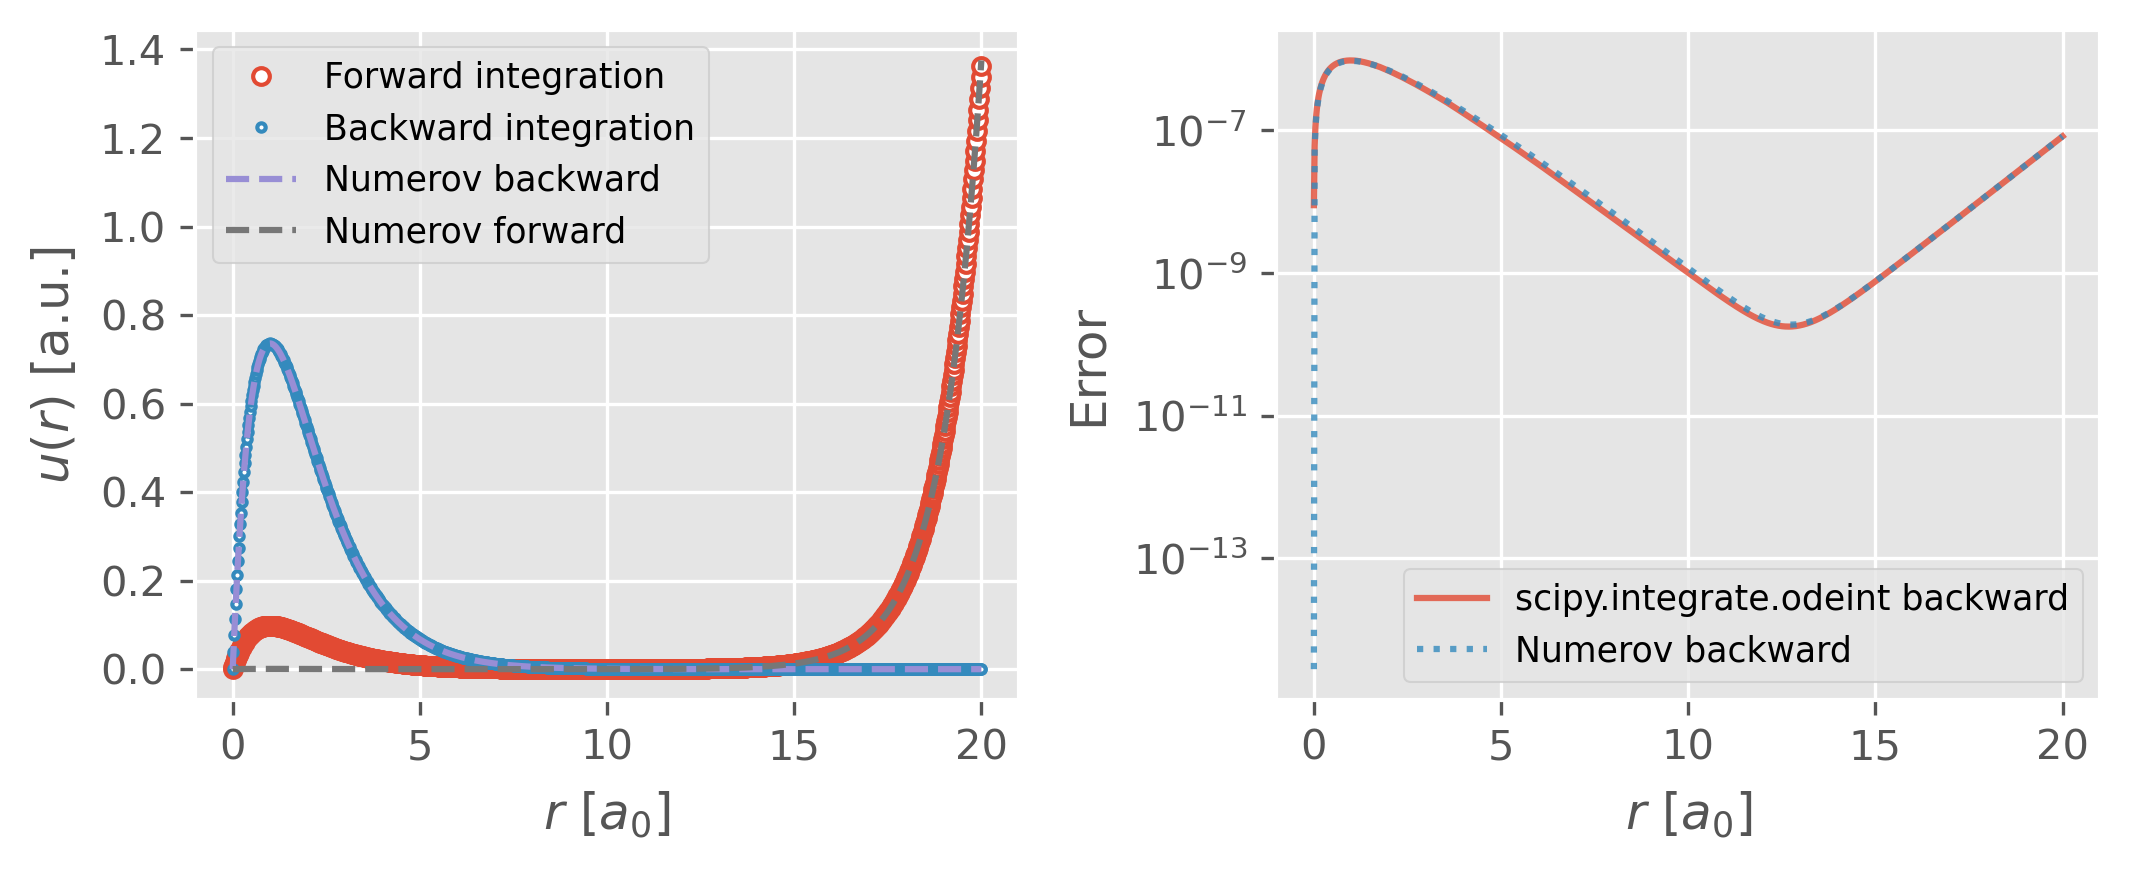

In [2]:
################################################################################
# Define the radial grid
r0 = np.linspace(1E-10, 20, 1000)

Z = 1
l = 0
n = 1

# forward integration from u(0)
ur1 = radial_wfc_scipy(r0, n, l, direction='F')
# backward integration from u(\infty)
ur2 = radial_wfc_scipy(r0, n, l, direction='B')
# backward integration from u(\infty) with Numerov method
ur3 = radial_wfc_numerov_backward(r0, n, l)
ur4 = radial_wfc_numerov_forward(r0, n, l)

################################################################################
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig = plt.figure(
    figsize=(7.2, 3.0),
    dpi=300
)
axes = [plt.subplot(1,2,ii+1) for ii in range(2)]

################################################################################
ax = axes[0]

ax.plot(
    r0, ur1,
    ls='none',
    ms=4, marker='o', mfc='white', mew=1.0, 
    zorder=1,
    label=r'Forward integration',
)

ax.plot(
    r0, ur2,
    ls='none',
    ms=2, marker='o', mfc='white', mew=1.0, 
    zorder=1,
    label=r'Backward integration',
)
ax.plot(r0,ur3,'--',label='Numerov backward')
ax.plot(r0,ur4,'--',label='Numerov forward')

# ax.plot(r0, 2*r0*np.exp(-r0), lw=1.0, color='cyan', zorder=2, label=r'Exact: $2r\cdot e^{-r}$')

ax.set_xlabel(r'$r$ [$a_0$]',   labelpad=5)
ax.set_ylabel(r'$u(r)$ [a.u.]', labelpad=5)

# ylim = list(ax.get_ylim())
# ylim[1] = 1.0
# ax.set_ylim(ylim)
ax.legend(loc='best', fontsize='small')

#################################################################################
ax = axes[1]

ax.semilogy(
    r0, 2*r0*np.exp(-r0) - ur2,
    ls='-', alpha=0.8,
    zorder=1,
    label=r'scipy.integrate.odeint backward',
)

ax.semilogy(
    r0, 2*r0*np.exp(-r0) - ur3,
    ls=':', alpha=0.8,
    zorder=1,
    label=r'Numerov backward',
)
ax.legend(loc='lower right', fontsize='small')

ax.set_xlabel(r'$r$ [$a_0$]',   labelpad=5)
ax.set_ylabel(r'Error', labelpad=5)

plt.tight_layout()
plt.savefig('fig1.png')
plt.show()

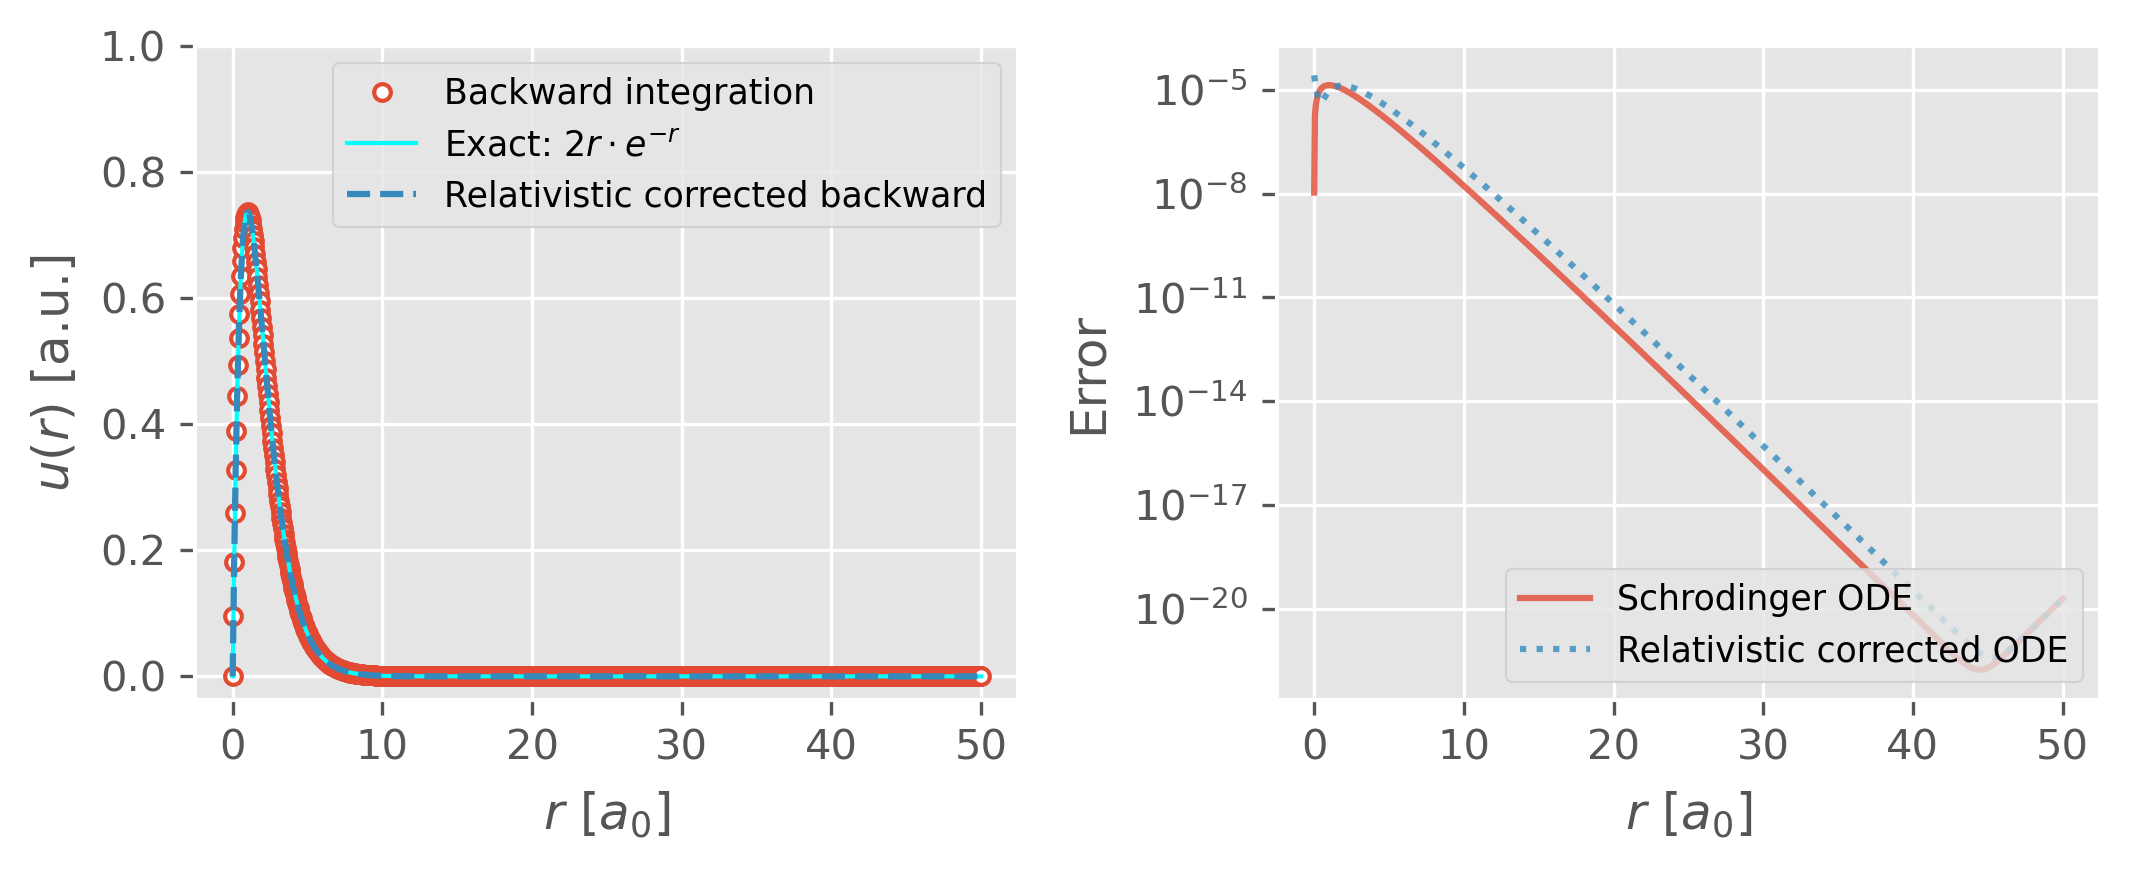

In [49]:
# Define the radial grid
r0 = np.linspace(1E-10, 50, 1000)

Z = 1
l = 0
n = 1

# forward integration from u(0)
# ur1 = radial_wfc_scipy(r0, n, l, Z=Z,direction='F')
# backward integration from u(\infty)
ur2 = radial_wfc_scipy(r0, n, l, direction='B')
# backward integration from u(\infty) with Numerov method
ur3 = radial_wfc_scipy(r0, n, l, Z=Z, direction='BR')
# ur4 = radial_wfc_numerov_forward(r0, n, l,Z=Z)
################################################################################
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig = plt.figure(
    figsize=(7.2, 3.0),
    dpi=300
)
axes = [plt.subplot(1,2,ii+1) for ii in range(2)]

################################################################################
ax = axes[0]

# ax.plot(
#     r0, ur1,
#     ls='none',
#     ms=4, marker='o', mfc='white', mew=1.0, 
#     zorder=1,
#     label=r'Forward integration',
# )

ax.plot(
    r0, ur2,
    ls='none',
    ms=4, marker='o', mfc='white', mew=1.0, 
    zorder=1,
    label=r'Backward integration',
)
ax.plot(r0, 2*r0*np.exp(-r0), lw=1.0, color='cyan', zorder=2, label=r'Exact: $2r\cdot e^{-r}$')

ax.plot(r0, ur3, '--',label=r'Relativistic corrected backward')
# ax.plot(r0, ur4, '--',label=r'Numerov forward')


ax.set_xlabel(r'$r$ [$a_0$]',   labelpad=5)
ax.set_ylabel(r'$u(r)$ [a.u.]', labelpad=5)

ylim = list(ax.get_ylim())
ylim[1] = 1.0
ax.set_ylim(ylim)
ax.legend(loc='best', fontsize='small')

#################################################################################
ax = axes[1]

ax.semilogy(
    r0, 2*r0*np.exp(-r0) - ur2,
    ls='-', alpha=0.8,
    zorder=1,
    label=r'Schrodinger ODE',
)

ax.semilogy(
    r0, 2*r0*np.exp(-r0) - ur3,
    ls=':', alpha=0.8,
    zorder=1,
    label=r'Relativistic corrected ODE',
)
ax.legend(loc='lower right', fontsize='small')

ax.set_xlabel(r'$r$ [$a_0$]',   labelpad=5)
ax.set_ylabel(r'Error', labelpad=5)

plt.tight_layout()
plt.savefig('fig1.png')
plt.show()


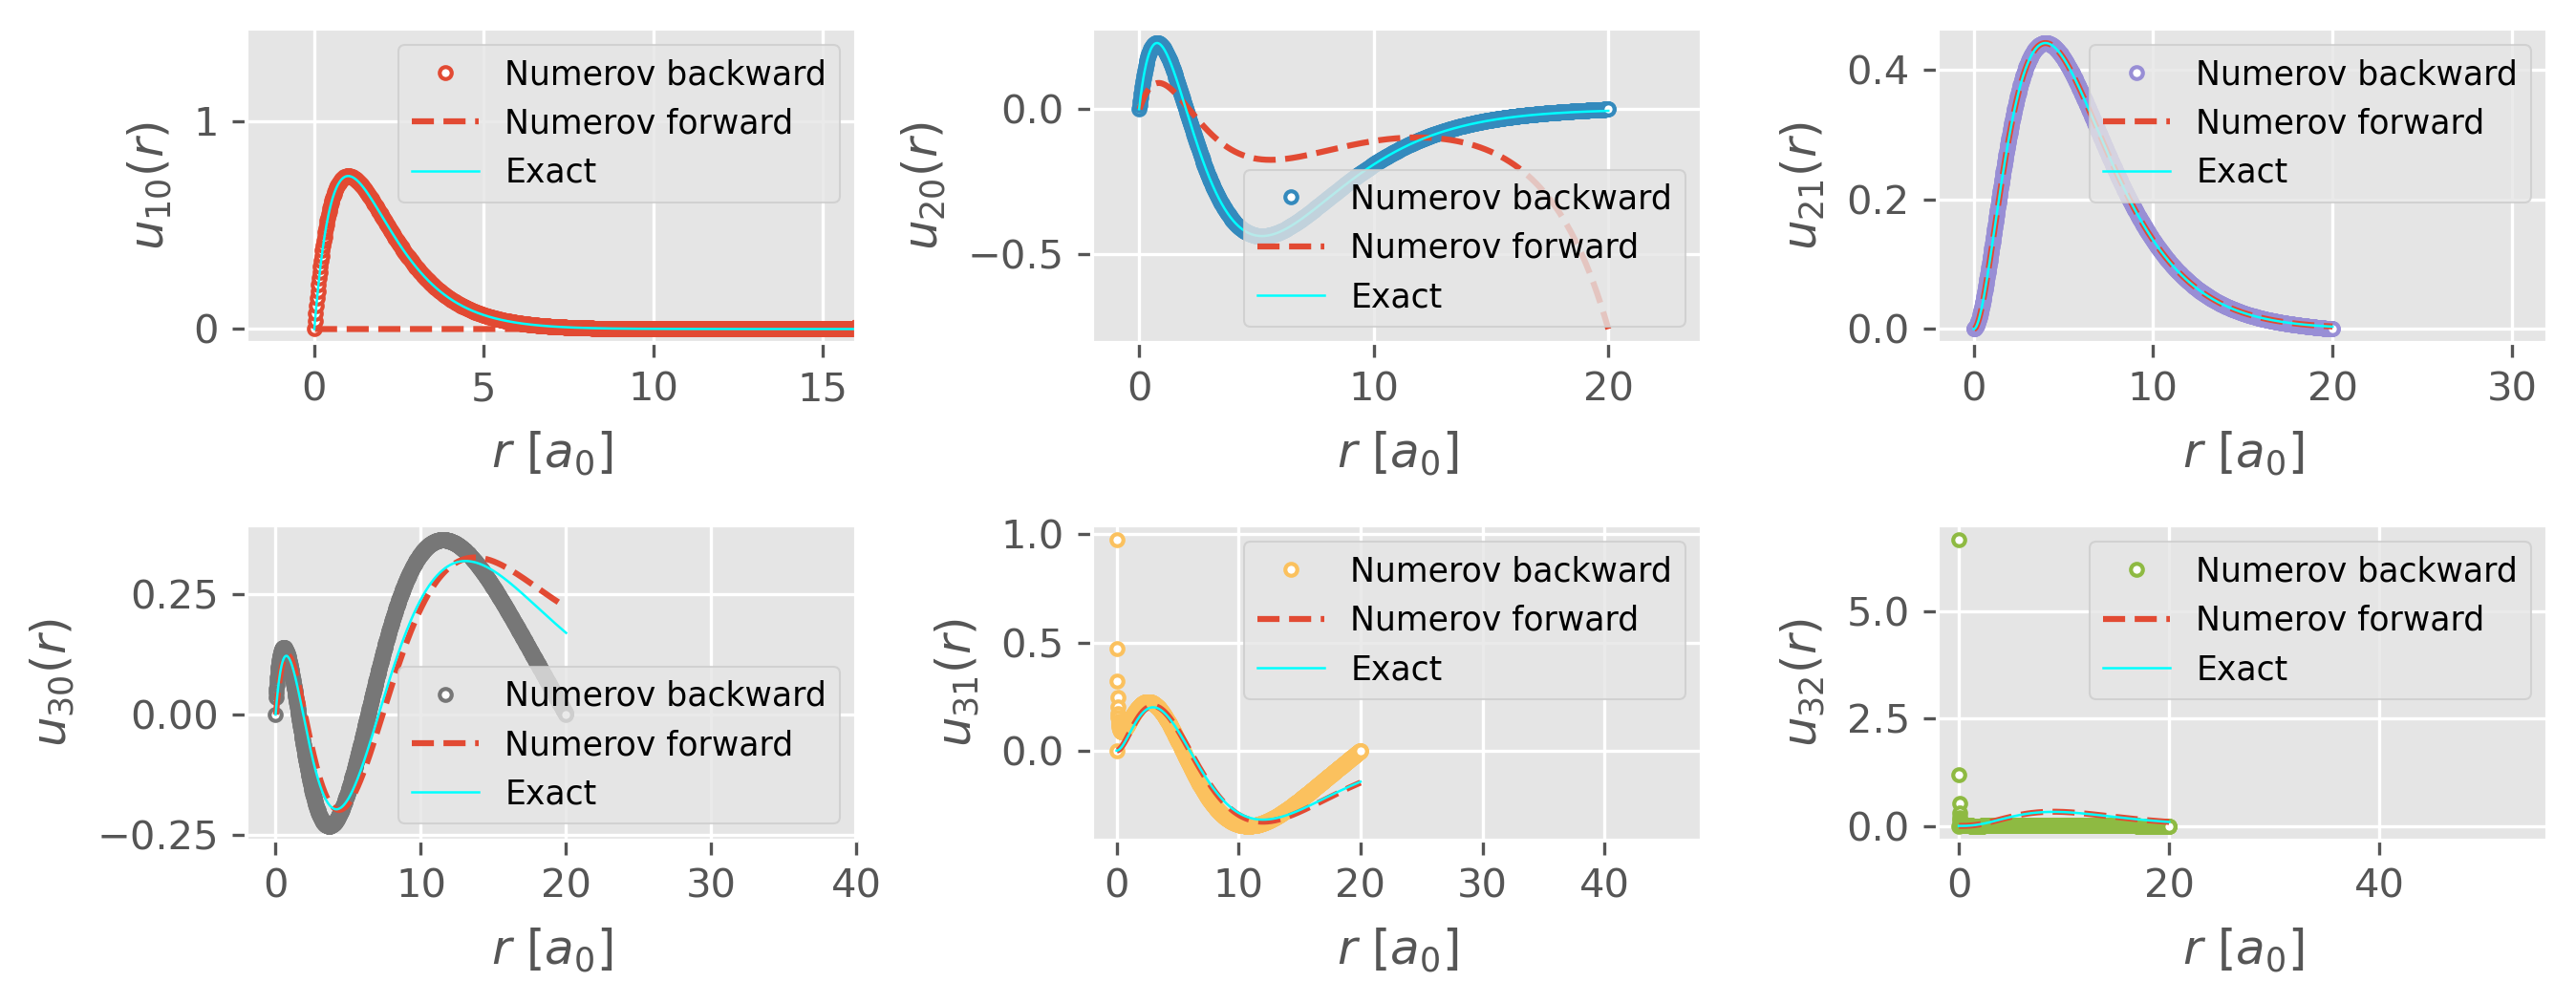

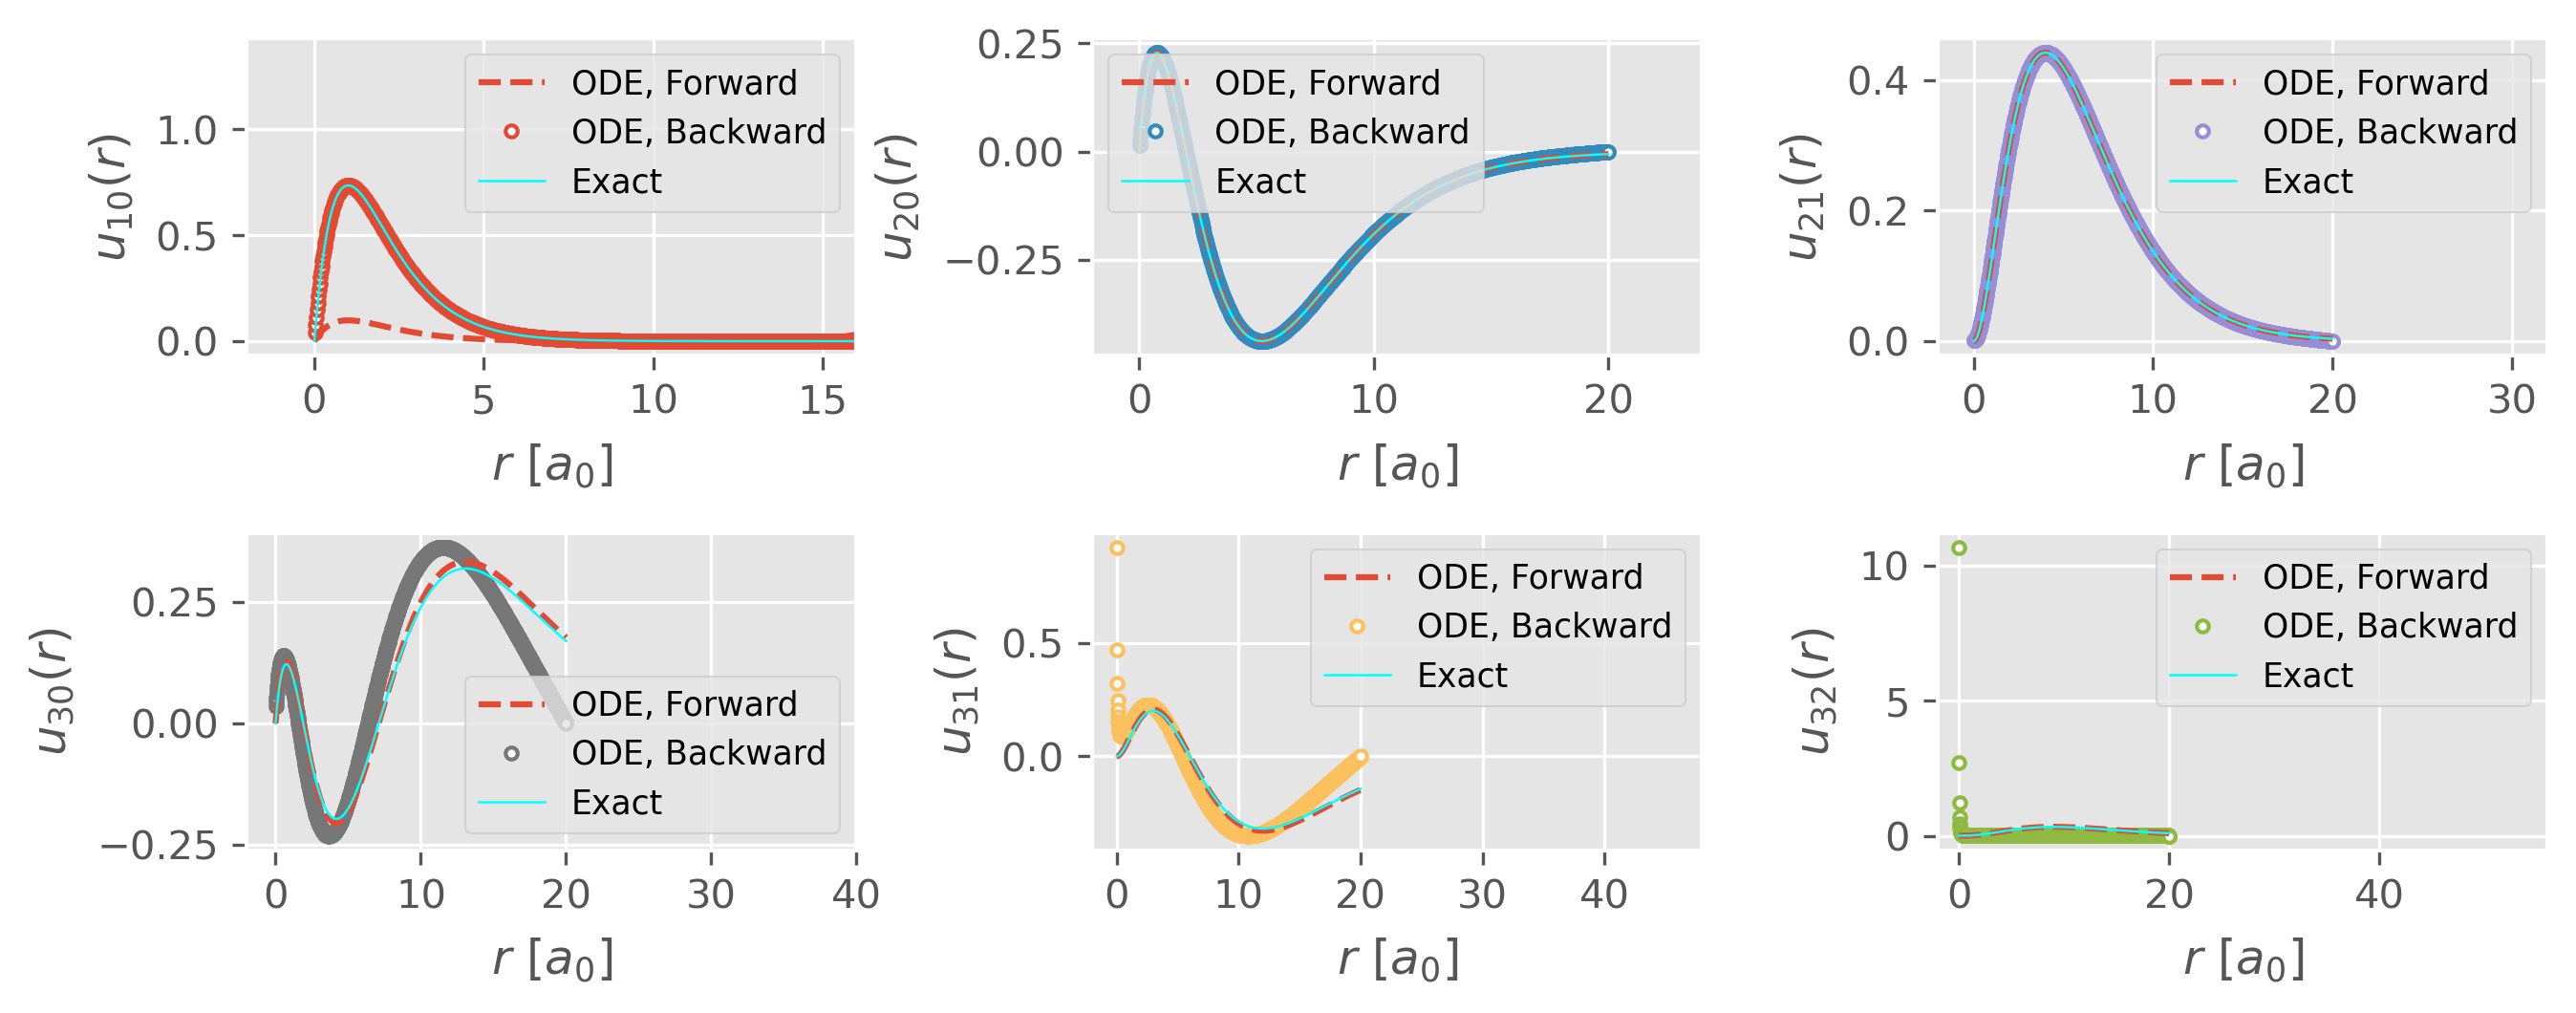

In [3]:

from sympy import lambdify
from sympy.abc import r, Z
from sympy.physics.hydrogen import R_nl
nls = [
    (1, 0),
    (2, 0),
    (2, 1),
    (3, 0),
    (3, 1),
    (3, 2)
]
ur0 = [
    lambdify((r, Z), r * R_nl(n, l, r, Z), 'numpy')(r0, 1) for n, l in nls
]
deltas = [0.01, -0.01, 0.01, 0.01, -0.01, 0.01]
ur2 = [radial_wfc_numerov_backward(r0, n, l, du=deltas[ii]) for ii, (n, l) in enumerate(nls)]
ur1 = [radial_wfc_numerov_forward(r0[1:], n, l, du=0.01) for ii, (n, l) in enumerate(nls)]


################################################################################
fig = plt.figure(
    figsize=(9.0, 3.6),
    dpi=300
)
axes = [plt.subplot(2, 3 ,ii+1) for ii in range(len(nls))]

for ii in range(len(nls)):
    ax = axes[ii]

    # ax.plot(
    #     r0[1:], ur1[ii],
    #     '--',
    #     color=plt.rcParams['axes.prop_cycle'].by_key()['color'][ii],
    #     zorder=1,
    #     label=r'Numerov forward',
    # )

    ax.plot(
        r0, ur2[ii],
        ls='none',
        ms=3, marker='o', mfc='white', mew=1.0, 
        color=plt.rcParams['axes.prop_cycle'].by_key()['color'][ii],
        zorder=1,
        label=r'Numerov backward',
    )

    ax.plot(
        r0[1:], ur1[ii],'--',
        label=r'Numerov forward',
    )

    ax.plot(r0, ur0[ii], lw=0.6, color='cyan', zorder=2,
            label=r'Exact')

    ax.set_xlabel(r'$r$ [$a_0$]',   labelpad=5)
    ax.set_ylabel(r'$u_{{ {}{} }}(r)$'.format(*nls[ii]), labelpad=5)

    ax.legend(loc='best', fontsize='small', ncol=1)

    ax.set_xlim(-2, 16 + ii * 8)
    # print(str(nls[ii]))
    # ax.set_title(str(nls[ii]))

plt.tight_layout()
plt.savefig('fig2.png')
plt.show()

################################################################################
Z = 1
l = 0
n = 1
nls = [
    (1, 0),
    (2, 0),
    (2, 1),
    (3, 0),
    (3, 1),
    (3, 2)
]

from sympy import lambdify
from sympy.abc import r, Z
from sympy.physics.hydrogen import R_nl

ur0 = [
    lambdify((r, Z), r * R_nl(n, l, r, Z), 'numpy')(r0, 1) for n, l in nls
]
deltas = [0.01, -0.01, 0.01, 0.01, -0.01, 0.01]
ur3 = [radial_wfc_scipy(r0, n, l,direction='F') for ii, (n, l) in enumerate(nls)]
ur4 = [radial_wfc_scipy(r0[1:], n, l,du=deltas[ii],direction='B') for ii, (n, l) in enumerate(nls)]

fig = plt.figure(
    figsize=(9.0, 3.6),
    dpi=300
)
axes = [plt.subplot(2, 3 ,ii+1) for ii in range(len(nls))]

for ii in range(len(nls)):
    ax = axes[ii]
    ax.plot(
        r0, ur3[ii],'--',
        label=r'ODE, Forward',
    )
    ax.plot(
        r0[1:], ur4[ii], ls='none',
        ms=3, marker='o', mfc='white', mew=1.0, 
        color=plt.rcParams['axes.prop_cycle'].by_key()['color'][ii],
        zorder=1,
        label=r'ODE, Backward',
    )
    ax.plot(r0, ur0[ii], lw=0.6, color='cyan', zorder=2,
            label=r'Exact')

    ax.set_xlabel(r'$r$ [$a_0$]',   labelpad=5)
    ax.set_ylabel(r'$u_{{ {}{} }}(r)$'.format(*nls[ii]), labelpad=5)

    ax.legend(loc='best', fontsize='small', ncol=1)

    ax.set_xlim(-2, 16 + ii * 8)
    # ax.set_title(str(nls[ii]))


plt.tight_layout()
plt.savefig('fig3.png')
plt.show()    

phase shift delta = 1.6


Text(0, 0.5, 'P(r)')

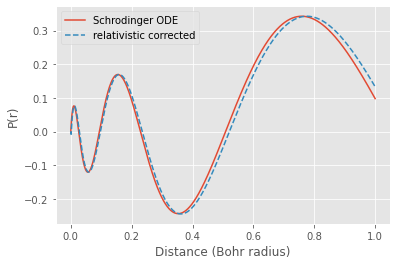

In [4]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
from abtem.ionization.transitions import SubshellTransitions
from scipy.interpolate import UnivariateSpline
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from ase import units

# plt.subplot(121)
# continuum_energy = ae.ETotal+self.epsilon/units.Hartree
r = np.linspace(1e-10, 1, 1000)
# epsilon =-1/n**2 

z = 79
n =1
lprime = 0
# epsilon =-z**2/n**2 *units.Rydberg
epsilon=100
k = np.sqrt(epsilon / units.Rydberg)

transitions = SubshellTransitions(Z = z, n = 1, l = 0, xc = 'PBE',epsilon=epsilon,order=1)
if 1:
    vr,_ = transitions.get_continuum_potential()
    vr = UnivariateSpline(r, vr(r))
    # vr = -250*(1/r**12-1/r**6)*r
    # vr = interp1d(r,vr,fill_value='extrapolate', bounds_error=False)
else:
    vr = -np.ones(r.size)*z
    vr = interp1d(r,vr,fill_value='extrapolate', bounds_error=False)

def schroedinger_derivative(y, r, l, e, vr):
    (u, up) = y
    # note vr is effective potential multiplied by radius:
    return np.array([up, (l * (l + 1) / r ** 2 + 2 * vr(r) / r - e) * u])

def schroedinger_derivative_relativistic_correct(y, r, l, e, vr):
    # fine structure constant
    alpha = 7.2973525693e-3 
    (u, up) = y
    dvdr = (vr.derivative(n=1)(r)-vr(r)/r)/r
    # note vr is effective potential multiplied by radius:
    return np.array([up, (l * (l + 1) / r ** 2 + 2 * vr(r) / r - e - 1/4*alpha**2 *(e-2*vr(r)/r)**2 + 1/2*alpha**2*l/r*dvdr) * u ])


ur = odeint(schroedinger_derivative, [0.0, 1.], r, args=(lprime, epsilon/units.Rydberg, vr))
ur_re = odeint(schroedinger_derivative_relativistic_correct, [0.0, -1.], r, args=(lprime, epsilon/units.Rydberg, vr))

# sqrt_k =  (2 * epsilon / units.Hartree * (
#                     1 + units.alpha ** 2 * epsilon / units.Hartree / 2)) ** .25
ur = ur[:, 0] / ur[:, 0].max() / np.sqrt(k) / np.sqrt(np.pi)
ur_re = ur_re[:, 0] / ur_re[:, 0].max() / np.sqrt(k) / np.sqrt(np.pi)

plt.cla()
plt.plot(r,ur,label='Schrodinger ODE')
plt.plot(r,ur_re, '--',label='relativistic corrected')


from scipy.special import spherical_jn,spherical_yn
rcut = r.max()
dr = r[-2]-r[-1]
A1 = (rcut-dr)*spherical_jn(lprime,k*(rcut-dr))*ur[-1]-rcut*spherical_jn(lprime,k*rcut)*ur[-2]
A2 = (rcut-dr)*spherical_yn(lprime,k*(rcut-dr))*ur[-1]-rcut*spherical_yn(lprime,k*rcut)*ur[-2]
# delta  = -np.arctan(A1/A2)
delta=1.6
print(f'phase shift delta = {delta}')
u00 = np.sqrt(1/np.pi/k)*np.sin(k*r-lprime*np.pi/2+np.log(2*k*r)/k+np.angle(lprime+1-1j/k)+delta)
# u00 = np.sqrt(1/np.pi/k)*np.sin(k*r-lprime*np.pi/2-np.log(2*k*r)/k+delta)
# plt.plot(r,spherical_jn(lprime,k*r),label='jn')
# plt.plot(r,spherical_yn(lprime,k*r),label='yn')

# plt.plot(r,u00,label='Asymptotic')

# urf = radial_wfc_scipy(r, E=epsilon/units.Rydberg, l=lprime,vr=vr(r),direction='F',du=1,state='Continuum')
# plt.plot(r,urf,label='ODE, forward')

# ur1 = radial_wfc_numerov_forward(r,E=epsilon/units.Rydberg,l=lprime,vr=vr(r),du=-0.1)
# plt.plot(r,ur1,'--',label='Numerov forward')
plt.legend()
plt.xlabel('Distance (Bohr radius)')
plt.ylabel('P(r)')


# plt.subplot(122)
# plt.plot(r,vr(r))

In [10]:
epsilon

-693.4444444444445

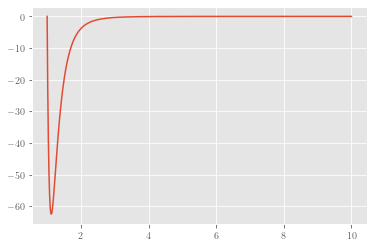

In [429]:
r = np.linspace(1,10,1000)
vr = 250*(1/r**12-1/r**6)
plt.plot(r,vr+l*(l+1)/r**2)


array([1.00000000e-10, 1.00027635e-10, 1.00055278e-10, ...,
       9.99447527e+01, 9.99723725e+01, 1.00000000e+02])

In [341]:
-np.log(2*k*r)

array([22.48665536, 22.48637904, 22.48610273, ..., -5.14381313,
       -5.14408945, -5.14436576])

In [185]:

delta

-1.2856011801729739

Text(0, 0.5, '$2Z/r+l(l+1)/r**2$')

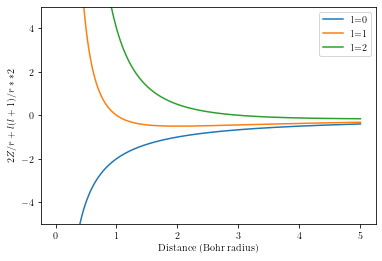

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc

Z = 1
r =np.linspace(0.01,5,1000)
for l in range(0,3):    
    v = (l*(l+1) / r**2) - (2*Z / r)
    plt.plot(r,v,label='l='+str(l))
plt.ylim([-5,5])
plt.legend()
plt.xlabel('Distance (Bohr radius)')
foo = r"$2Z/r+l(l+1)/r**2$"
# rc('text', usetex=True)
plt.ylabel(foo)

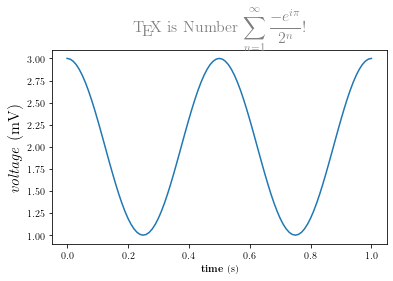

In [20]:
import numpy as np
import matplotlib.pyplot as plt


# Example data
t = np.arange(0.0, 1.0 + 0.01, 0.01)
s = np.cos(4 * np.pi * t) + 2

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(t, s)

plt.xlabel(r'\textbf{time} (s)')
plt.ylabel(r'\textit{voltage} (mV)',fontsize=16)
plt.title(r"\TeX\ is Number "
          r"$\displaystyle\sum_{n=1}^\infty\frac{-e^{i\pi}}{2^n}$!",
          fontsize=16, color='gray')
# Make room for the ridiculously large title.
plt.subplots_adjust(top=0.8)

plt.savefig('tex_demo')
plt.show()